In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from research_utils import read_csv_imc, make_continuos_df
from collections import OrderedDict

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def calc_mid_price(df: pd.DataFrame):
    df['mid_price'] = (df['bid_price_1'] + df['ask_price_1']) / 2
    df = df[["timestamp", "mid_price", "product"]]
    return df

In [8]:
df_prices_day_0 = read_csv_imc(r"..\data\round-3-island-data-bottle\prices_round_3_day_0.csv")
df_prices_day_1 = read_csv_imc(r"..\data\round-3-island-data-bottle\prices_round_3_day_1.csv")
df_prices_day_2 = read_csv_imc(r"..\data\round-3-island-data-bottle\prices_round_3_day_2.csv")

prices_dict = OrderedDict()
prices_dict["day0"] = calc_mid_price(df_prices_day_0),
prices_dict["day1"] = calc_mid_price(df_prices_day_1),
prices_dict["day2"] = calc_mid_price(df_prices_day_2),

In [9]:
big_boi_df = make_continuos_df(big_dict=prices_dict, key="timestamp")

df_c = big_boi_df.loc[big_boi_df["product"] == "CHOCOLATE"].drop('product', axis=1)
df_s = big_boi_df.loc[big_boi_df["product"] == "STRAWBERRIES"].drop('product', axis=1)
df_r = big_boi_df.loc[big_boi_df["product"] == "ROSES"].drop('product', axis=1)
df_g = big_boi_df.loc[big_boi_df["product"] == "GIFT_BASKET"].drop('product', axis=1)

display(df_c.head())
display(df_s.head())
display(df_r.head())
display(df_s.head())

,timestamp,mid_price
0,0,8000.0
5,100,8001.5
10,200,8001.0
15,300,8002.5
16,400,8002.0


,timestamp,mid_price
1,0,4000.0
7,100,3999.5
11,200,3999.5
12,300,3999.5
17,400,3999.5


,timestamp,mid_price
2,0,15000.0
6,100,15000.0
8,200,15000.5
13,300,15000.0
18,400,14997.5


,timestamp,mid_price
1,0,4000.0
7,100,3999.5
11,200,3999.5
12,300,3999.5
17,400,3999.5


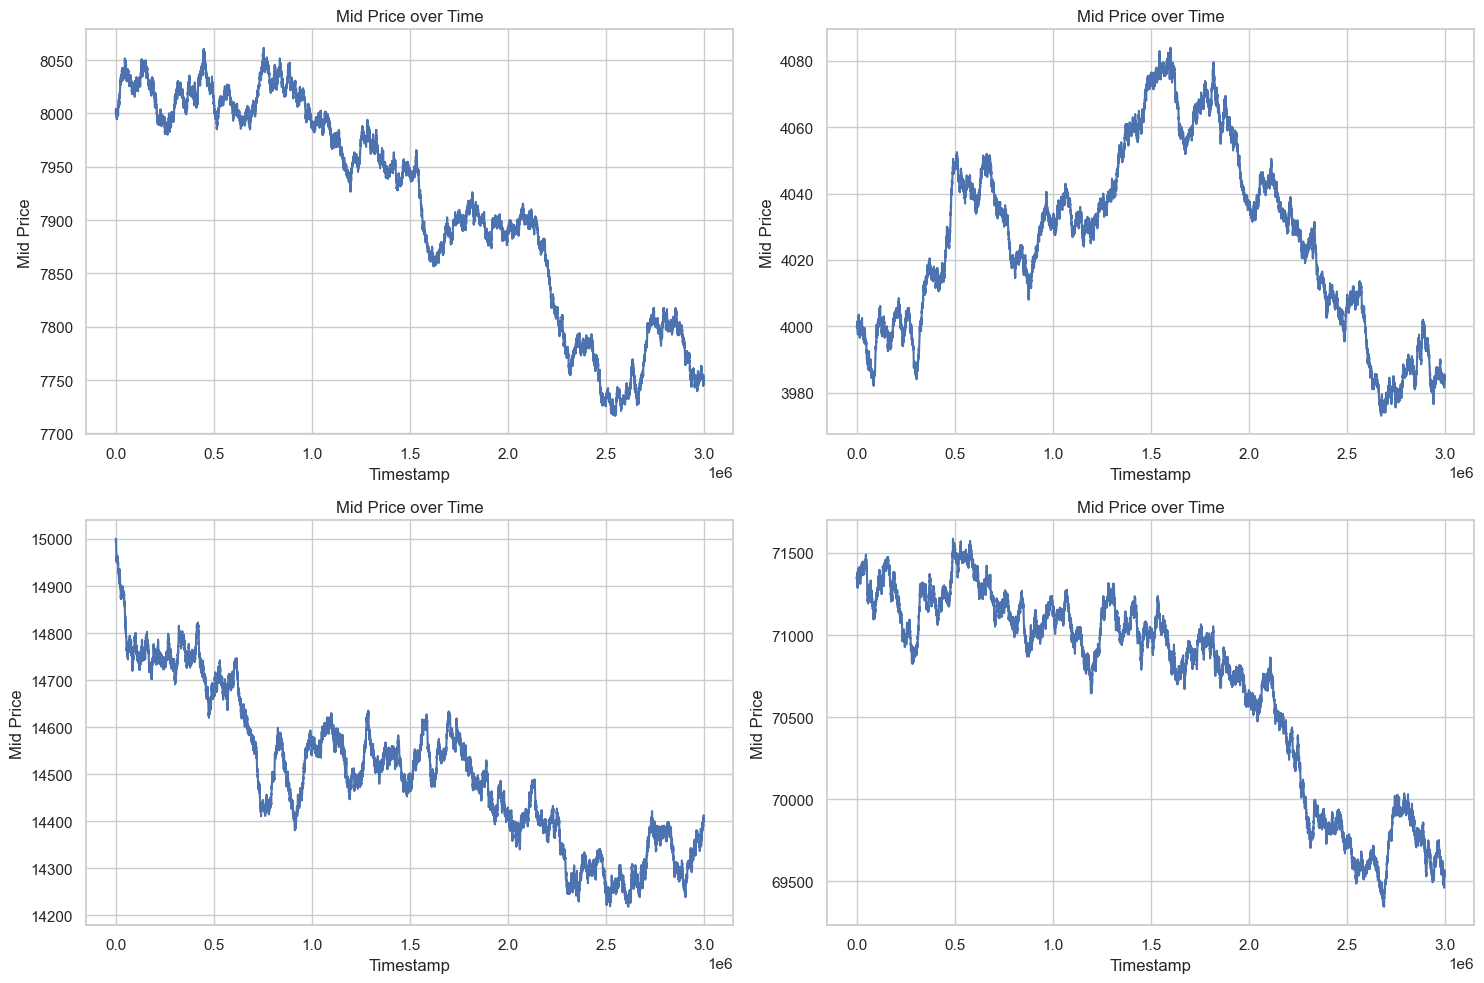

In [10]:
commodities_df = [df_c, df_s, df_r, df_g]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axs = axs.flatten()
for ax, df in zip(axs, commodities_df):
    ax.plot(df['timestamp'], df['mid_price'])
    ax.set_title('Mid Price over Time')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Mid Price')
    ax.grid(True)

plt.tight_layout()  
plt.show()

In [11]:
def copy_and_set_index(df_c, df_s, df_r, df_g):
    df_c = df_c.copy()
    df_s = df_s.copy()
    df_r = df_r.copy()
    df_g = df_g.copy()
    df_c.set_index("timestamp", inplace=True)
    df_s.set_index("timestamp", inplace=True)
    df_r.set_index("timestamp", inplace=True)
    df_g.set_index("timestamp", inplace=True)
    return df_c, df_s, df_r, df_g


def make_heatmap(df_c, df_s, df_r, df_g):
    df_c, df_s, df_r, df_g = copy_and_set_index(df_c, df_s, df_r, df_g)
    prices = pd.DataFrame(
        {
            "Chocolate": df_c["mid_price"],
            "Strawberries": df_s["mid_price"],
            "Roses": df_r["mid_price"],
            "Gift_Basket": df_g["mid_price"],
        }
    )

    corr_matrix = prices.corr()
    display(corr_matrix)

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", linewidths=0.5)
    plt.title("Cross-Correlation Matrix of Mid Prices")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()


def plot_pair(df_1, df_2, normalize=False, title=None):
    df_1 = df_1.copy()
    df_2 = df_2.copy()
    df_1.set_index("timestamp", inplace=True)
    df_2.set_index("timestamp", inplace=True)

    if normalize:
        df_1["mid_price_normalized"] = (df_1["mid_price"] - df_1["mid_price"].min()) / (
            df_1["mid_price"].max() - df_1["mid_price"].min()
        )
        df_2["mid_price_normalized"] = (df_2["mid_price"] - df_2["mid_price"].min()) / (
            df_2["mid_price"].max() - df_2["mid_price"].min()
        )

    plt.figure(figsize=(15, 6))
    plt.plot(
        df_1.index,
        df_1["mid_price"] if not normalize else df_1["mid_price_normalized"],
        label="DF1 Mid Price",
    )
    plt.plot(
        df_2.index,
        df_2["mid_price"] if not normalize else df_2["mid_price_normalized"],
        label="DF2 Mid Price",
    )
    plt.title(title or "Prices overlayed")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.show()


def plot_spread(df_1, df_2, title=None):
    df_1 = df_1.copy()
    df_2 = df_2.copy()
    df_1.set_index("timestamp", inplace=True)
    df_2.set_index("timestamp", inplace=True)

    price_spread = df_1["mid_price"] - df_2["mid_price"]
    plt.figure(figsize=(15, 6))
    plt.plot(price_spread.index, price_spread, label="Price Spread (DF1 - DF2)")
    plt.axhline(
        y=price_spread.mean(),
        color="r",
        linestyle="--",
        label=f"Avg Rolling Corr: {price_spread.mean()}",
    )
    plt.title(title or "Price Spread Between DF1 and DF2")
    plt.xlabel("Timestamp")
    plt.ylabel("Spread")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_zscores_and_price_ratios(df_1, df_2, title=None, sma1=100, sma2=200, normalize=False):
    df_1 = df_1.copy()
    df_2 = df_2.copy()
    df_1.set_index("timestamp", inplace=True)
    df_2.set_index("timestamp", inplace=True)

    def zscore(series):
        return (series - series.mean()) / np.std(series)

    ratios = df_1["mid_price"] / df_2["mid_price"]
    plt.figure(figsize=(15, 6))
    plt.plot(zscore(ratios))
    plt.axhline(zscore(ratios).mean())
    plt.axhline(1.0, color="red")
    plt.axhline(-1.0, color="green")
    plt.title("ZScore Between DF1 and DF2")
    plt.xlabel("Timestamp")
    plt.ylabel("Zsores")
    plt.legend()
    plt.grid(True)
    plt.show()

    ratios_sma1 = ratios.rolling(window=sma1, center=False).mean()
    ratios_sma2 = ratios.rolling(window=sma2, center=False).mean()
    stds_sma = ratios.rolling(window=sma2, center=False).std()
    zscore_sma_pair = (ratios_sma1 - ratios_sma2) / stds_sma
    plt.figure(figsize=(15, 6))
    plt.plot(ratios.index, ratios.values)
    plt.plot(ratios_sma1.index, ratios_sma1.values)
    plt.plot(ratios_sma2.index, ratios_sma2.values)
    plt.title("Ratios w/ SMAs")
    plt.xlabel("Timestamp")
    plt.ylabel("Price Ratio")
    plt.legend(["Ratio", f"{sma1} Ratio SMA", f"{sma2} Ratio SMA"])
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(20, 9))
    zscore_sma_pair.plot()
    plt.axhline(0, color="black")
    plt.axhline(1.0, color="red", linestyle="--")
    plt.axhline(-1.0, color="green", linestyle="--")
    plt.legend(["Rolling Ratio z-Score", "Mean", "+1", "-1"])
    plt.title("Rolling ratio z-score")
    plt.xlabel("Timestamp")
    plt.ylabel("Zsores")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(20, 9))
    ratios.plot()
    buy = ratios.copy()
    sell = ratios.copy()
    buy[zscore_sma_pair > -1] = 0
    sell[zscore_sma_pair < 1] = 0
    buy.plot(color="g", linestyle="None", marker="^")
    sell.plot(color="r", linestyle="None", marker="^")
    x1, x2, _, _ = plt.axis()
    plt.title("Buy and Sell Signals for Pair Ratios")
    plt.axis((x1, x2, ratios.min(), ratios.max()))
    plt.legend(["Ratio", "Buy Signal", "Sell Signal"])
    plt.xlabel("Timestamp")
    plt.ylabel("Price Ratio")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(20, 9))
    if normalize:
        df_1["mid_price"] = (df_1["mid_price"] - df_1["mid_price"].min()) / (
            df_1["mid_price"].max() - df_1["mid_price"].min()
        )
        df_2["mid_price"] = (df_2["mid_price"] - df_2["mid_price"].min()) / (
            df_2["mid_price"].max() - df_2["mid_price"].min()
        )
    
    s1 = df_1["mid_price"]
    s1.plot()
    s2 = df_2["mid_price"]
    s2.plot()

    buyR = 0 * s1.copy()
    sellR = 0 * s2.copy()

    buyR[buy != 0] = s1[buy != 0]
    sellR[buy != 0] = s2[buy != 0]
    buyR[sell != 0] = s2[sell != 0]
    sellR[sell != 0] = s1[sell != 0]

    buyR.plot(color="g", linestyle="None", marker="^")
    sellR.plot(color="r", linestyle="None", marker="^")
    x1, x2, _, _ = plt.axis()
    plt.title("Buy and Sell Signals for Pair")
    plt.axis((x1, x2, min(s1.min(), s2.min()), max(s1.max(), s2.max())))
    plt.legend(["df1", "df2", "Buy Signal", "Sell Signal"])
    plt.grid(True)
    plt.show()


def plot_rolling_corr(df_1, df_2, window_size=50, title=None):
    df_1 = df_1.copy()
    df_2 = df_2.copy()
    df_1.set_index("timestamp", inplace=True)
    df_2.set_index("timestamp", inplace=True)
    rolling_corr = df_1["mid_price"].rolling(window=window_size).corr(df_2["mid_price"])
    avg_rolling_corr = rolling_corr.mean()
    plt.figure(figsize=(15, 6))
    rolling_corr.plot(title=title or f"{window_size} Rolling Correlation")
    plt.axhline(
        y=avg_rolling_corr,
        color="r",
        linestyle="--",
        label=f"Avg Rolling Corr: {avg_rolling_corr}",
    )
    plt.xlabel("Date")
    plt.ylabel("Rolling Correlation")
    plt.grid(True)
    plt.show()

,Chocolate,Strawberries,Roses,Gift_Basket
Chocolate,1.000000,0.273545,0.826358,0.947339
Strawberries,0.273545,1.000000,0.148667,0.498003
Roses,0.826358,0.148667,1.000000,0.850830
Gift_Basket,0.947339,0.498003,0.850830,1.000000


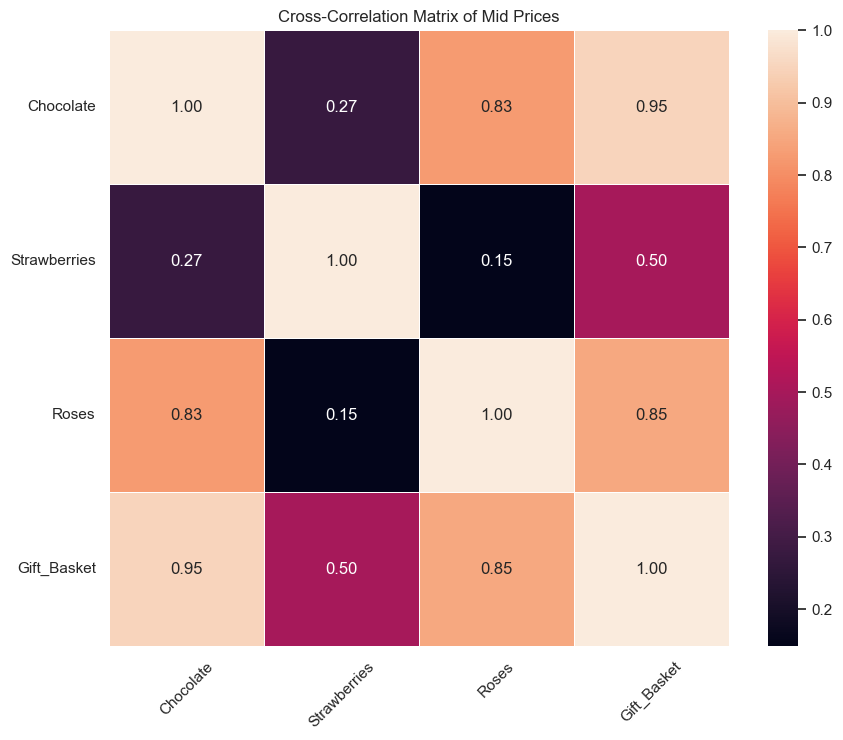

In [12]:
make_heatmap(df_c=df_c, df_s=df_s, df_r=df_r, df_g=df_g)

In [120]:
df_1_training = df_g
df_2_training = df_s

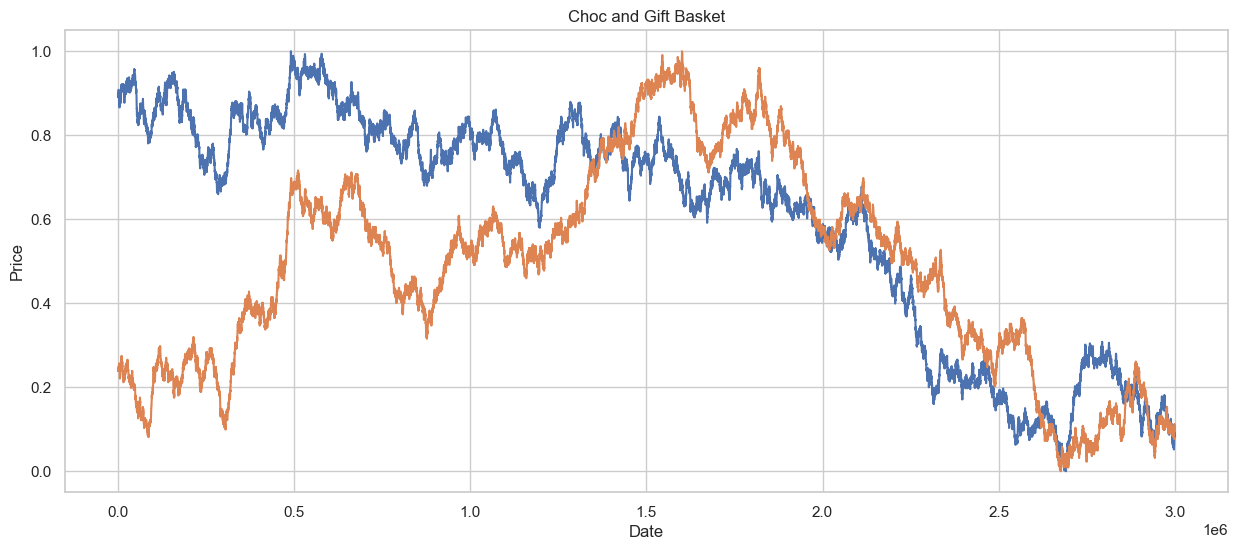

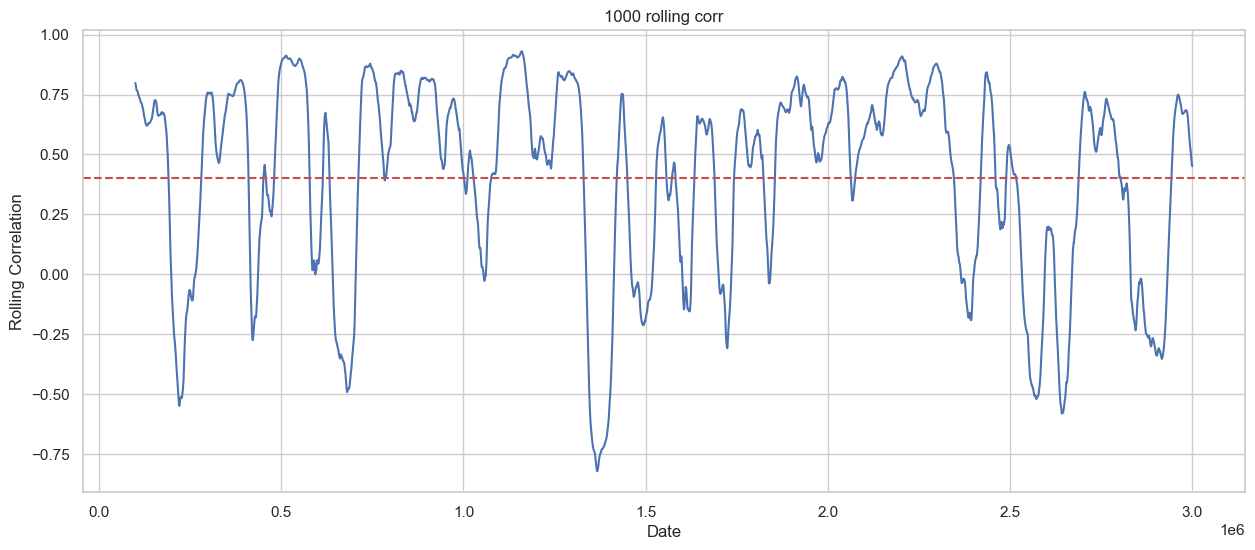

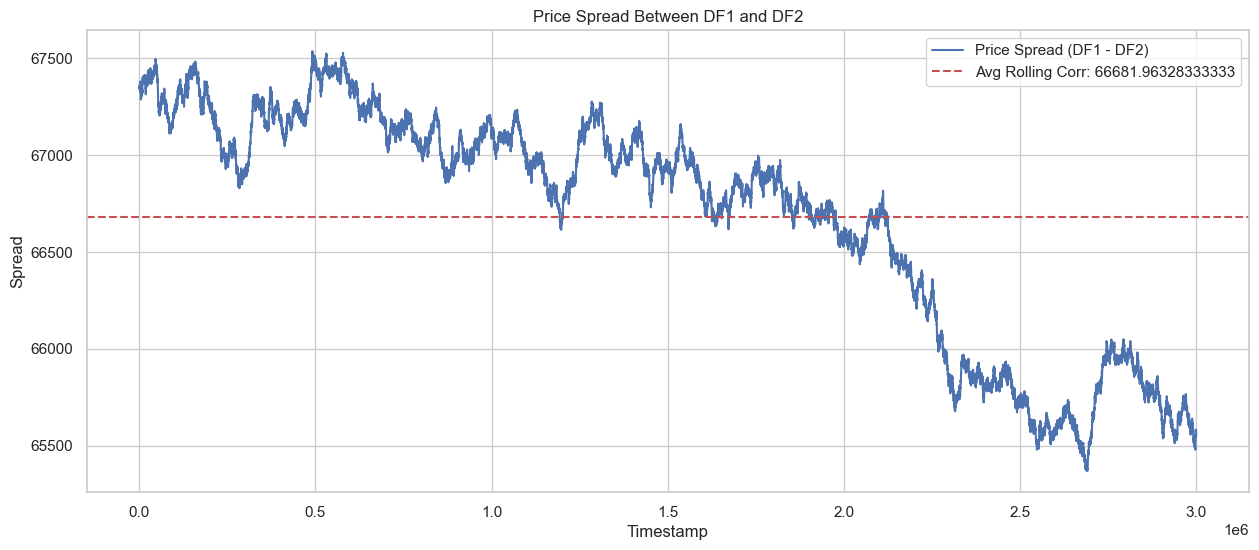

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


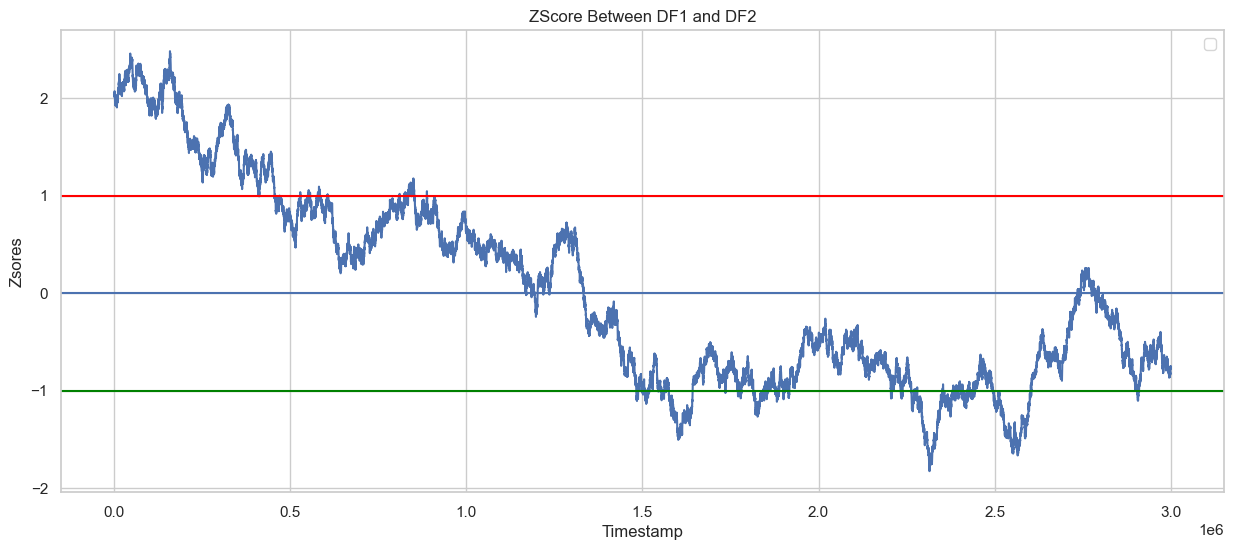

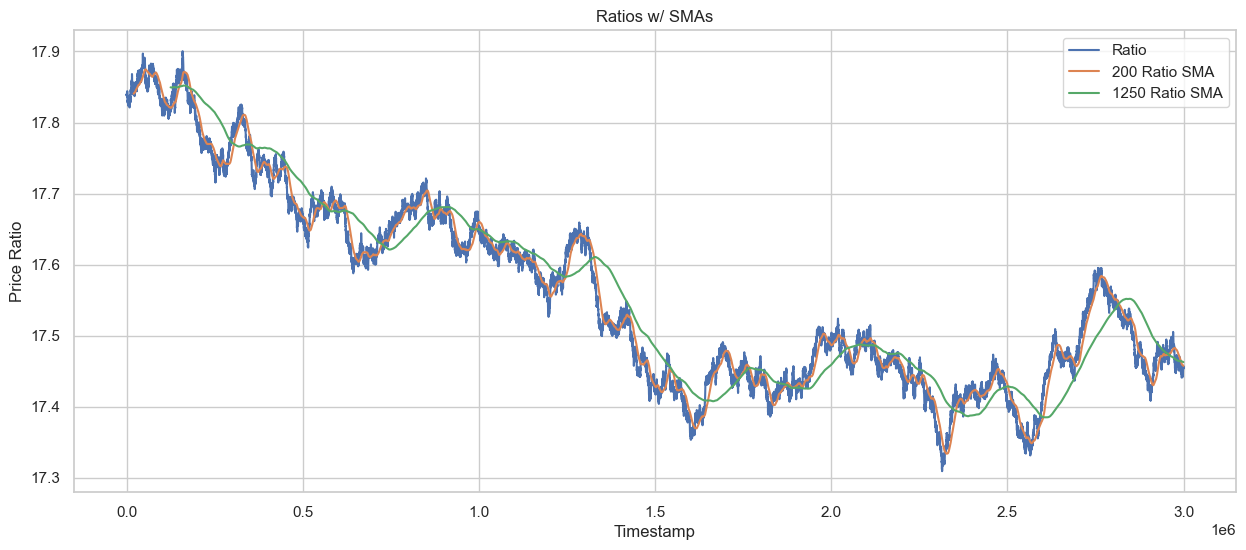

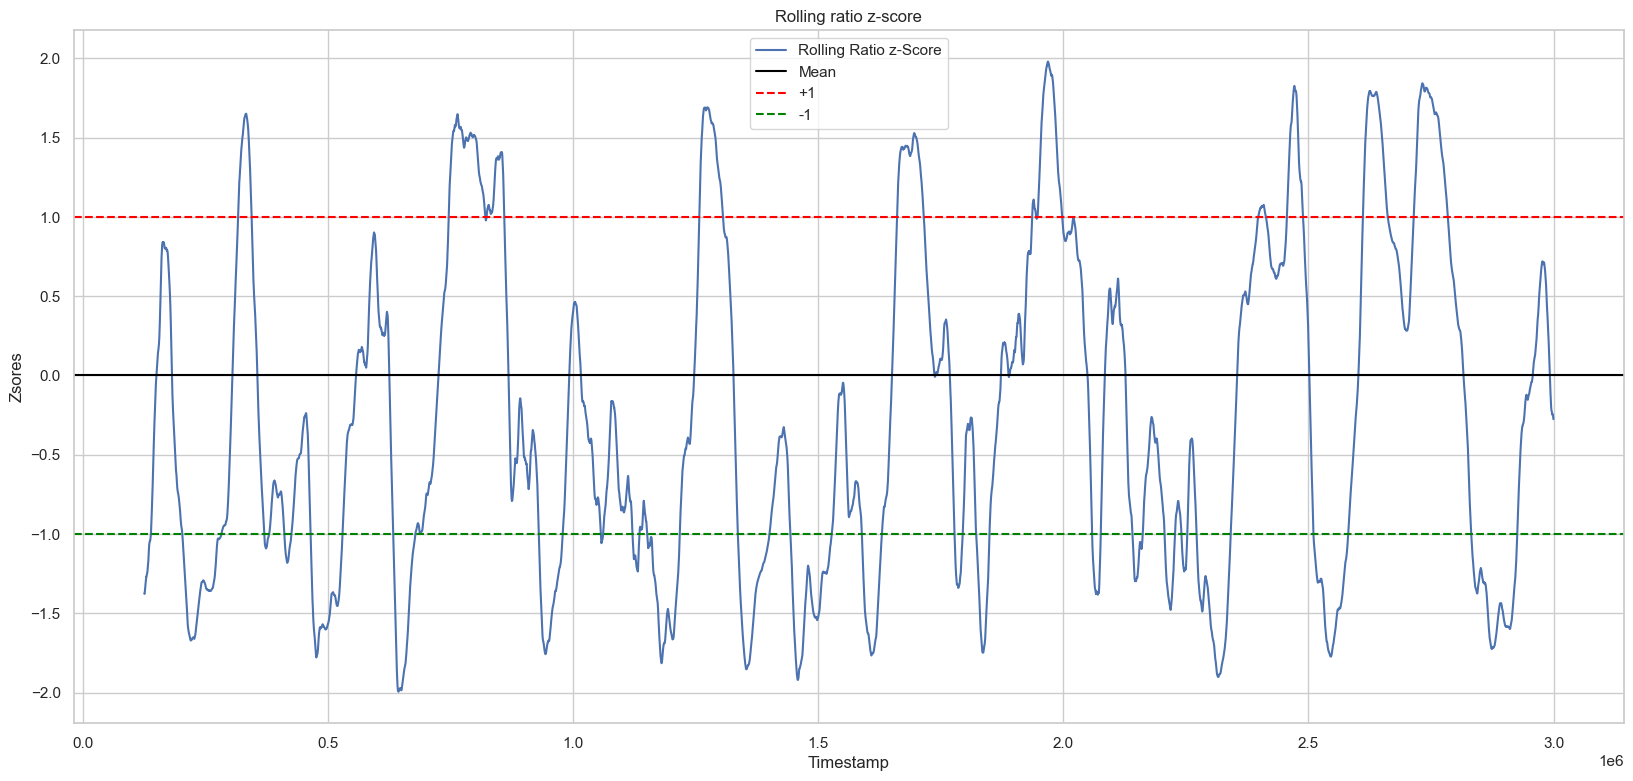

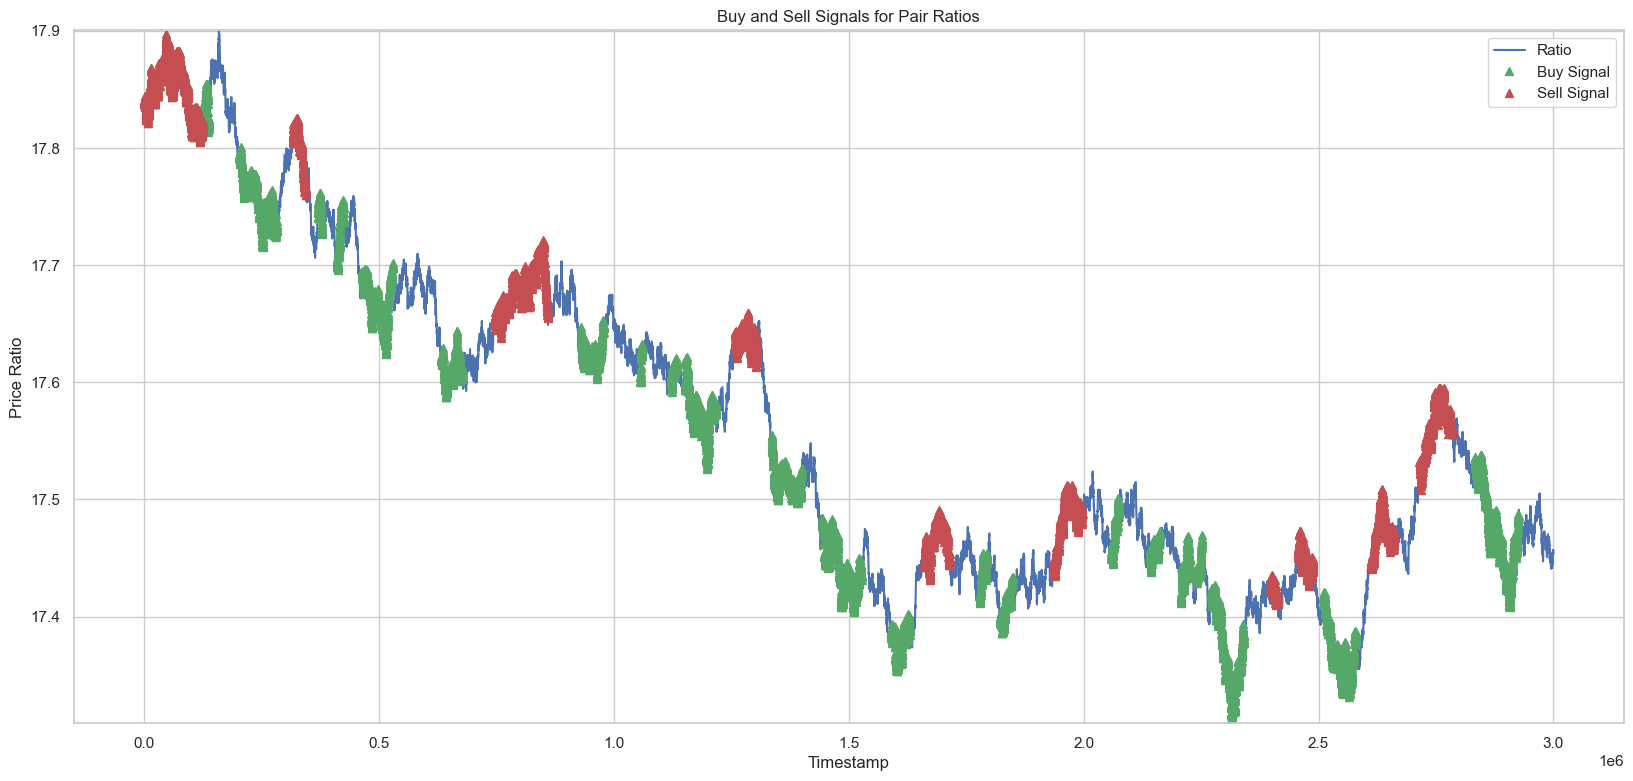

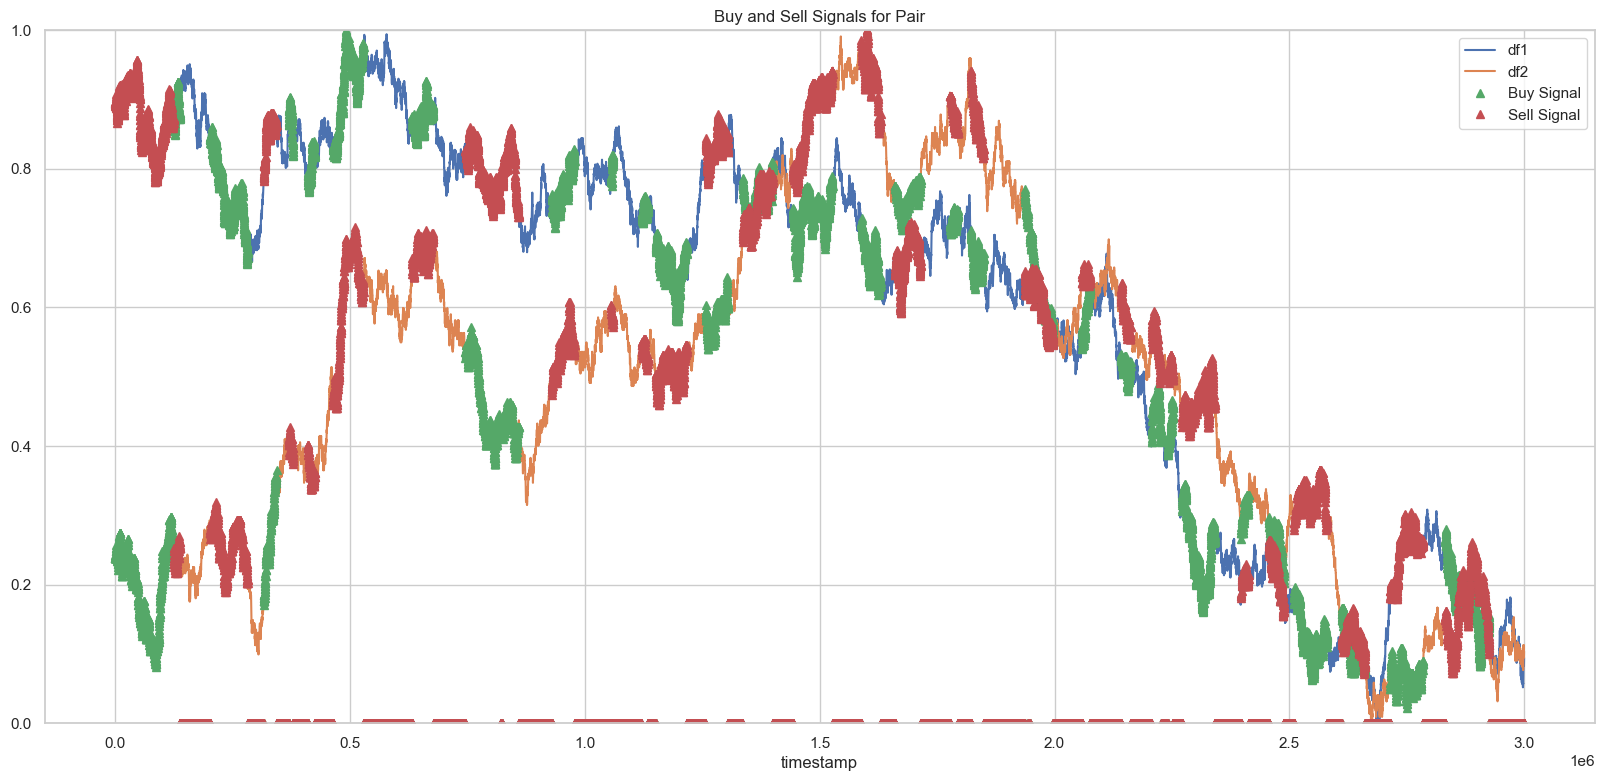

In [122]:
plot_pair(df_1_training, df_2_training, normalize=True, title="Choc and Gift Basket")
plot_rolling_corr(df_1_training, df_2_training, 1000, title="1000 rolling corr")
plot_spread(df_1_training, df_2_training)
plot_zscores_and_price_ratios(df_1_training, df_2_training, title="Choc and Gift Basket", sma1=200, sma2=1250, normalize=True)

In [119]:
def simple_backtest_trade(df_1, df_2, sma1, sma2):
    df_1 = df_1.copy()
    df_2 = df_2.copy()
    
    if df_1['timestamp'].duplicated().any():
        df_1 = df_1.drop_duplicates(subset='timestamp')
    if df_2['timestamp'].duplicated().any():
        df_2 = df_2.drop_duplicates(subset='timestamp')

    df_1.set_index("timestamp", inplace=True)
    df_2.set_index("timestamp", inplace=True)

    ratios = df_1["mid_price"] / df_2["mid_price"]

    ratios_sma1 = ratios.rolling(window=sma1, center=False).mean()
    ratios_sma2 = ratios.rolling(window=sma2, center=False).mean()
    stds_sma = ratios.rolling(window=sma2, center=False).std()
    zscore_sma_pair = (ratios_sma1 - ratios_sma2) / stds_sma
    
    money = 0
    count1 = 0
    count2 = 0
    for timestamp, z in zscore_sma_pair.iteritems():
        if pd.isna(z):
            continue
        if z < -1:
            # Buying df_1 and selling df_2
            money += df_1.at[timestamp, "mid_price"] - df_2.at[timestamp, "mid_price"] * ratios.at[timestamp]
            count1 -= 1
            count2 += ratios.at[timestamp]
        elif z > 1:
            # Selling df_1 and buying df_2
            money -= df_1.at[timestamp, "mid_price"] - df_2.at[timestamp, "mid_price"] * ratios.at[timestamp]
            count1 += 1
            count2 -= ratios.at[timestamp]
        elif abs(z) < 0.97:
            # Unwinding positions
            money += df_1.at[timestamp, "mid_price"] * count1 + df_2.at[timestamp, "mid_price"] * count2
            count1 = 0
            count2 = 0

    return f"Final PnL: {money}"

In [123]:
simple_backtest_trade(df_1_training, df_2_training, sma1=200, sma2=1250)

'Final PnL: -516042.45202809945'